In [1]:
import os
import sys

sys.stderr = open(os.devnull, "w")
    
import logging
logging.getLogger('tensorflow').disabled = True
# Suppress logging warnings
os.environ["GRPC_VERBOSITY"] = "FATAL"
os.environ["GLOG_minloglevel"] = "3"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import tensorflow as tf
from keras import layers
from tensorflow.keras.datasets import mnist, fashion_mnist
import keras_tuner as kt

import numpy as np
from matplotlib import pyplot as plt


seed = 42
tf.keras.utils.set_random_seed(seed)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.autograph.set_verbosity(1)

os.environ["XLA_FLAGS"] = "--xla_gpu_cuda_data_dir=" 

tf.get_logger().setLevel("ERROR")
logging.getLogger("tensorflow").setLevel(logging.ERROR)
logging.getLogger("absl").setLevel(logging.ERROR)
tf.config.optimizer.set_jit(False)  # Disable XLA to avoid logs

E0000 00:00:1738777584.595462   32759 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1738777584.601304   32759 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Blind source separation

This project aims to separate an image, formed as the sum of two images, into its original components.

The two source images, img1 and img2, are drawn from different datasets: MNIST and Fashion-MNIST, respectively.

No preprocessing is allowed. The neural network receives the combined image (img1 + img2) as input and outputs the predicted components (hat_img1,hat_img2).

Performance is evaluated using the mean squared error (MSE) between the predicted and ground-truth images.

Both datasets (MNIST and Fashion-MNIST) are grayscale. For simplicity, all samples are padded to a (32,32) resolution.

In [2]:
(mnist_x_train, mnist_y_train), (mnist_x_test, mnist_y_test) = mnist.load_data()
print(np.shape(mnist_x_train))
(fashion_mnist_x_train, fashion_mnist_y_train), (fashion_mnist_x_test, fashion_mnist_y_test) = fashion_mnist.load_data()
#normnalize in and pad
mnist_x_train = np.pad(mnist_x_train,((0,0),(2,2),(2,2)))/255.
print(np.shape(mnist_x_train))
mnist_x_test = np.pad(mnist_x_test,((0,0),(2,2),(2,2)))/255.
fashion_mnist_x_train = np.pad(fashion_mnist_x_train,((0,0),(2,2),(2,2)))/255.
fashion_mnist_x_test = np.pad(fashion_mnist_x_test,((0,0),(2,2),(2,2)))/255.

(60000, 28, 28)
(60000, 32, 32)


In [3]:
print(np.shape(mnist_x_train))

(60000, 32, 32)


Here is a simple datagenerator.

In [4]:
def datagenerator(x1,x2,batchsize):
    n1 = x1.shape[0]
    n2 = x2.shape[0]
    while True:
        num1 = np.random.randint(0, n1, batchsize)
        num2 = np.random.randint(0, n2, batchsize)

        x_data = (x1[num1] + x2[num2]) / 2.0
        y_data = (x1[num1], x2[num2])

        yield x_data, y_data

Let us define a generator with batchsize=1 and let's test it.

In [5]:
onegen = datagenerator(mnist_x_test,fashion_mnist_x_test,1)

Let us look at some input-output pairs

In [6]:
def show_images(x,y1,y2):
    fig, ax = plt.subplots(1,3,figsize=(12,4))
    ax[0].imshow(x,cmap='gray')
    ax[0].title.set_text('Input')
    ax[0].axis('off')
    ax[1].imshow(y1,cmap='gray')
    ax[1].title.set_text('mnist')
    ax[1].axis('off')
    ax[2].imshow(y2,cmap='gray')
    ax[2].title.set_text('fashion_mnist')
    ax[2].axis('off')
    plt.show()

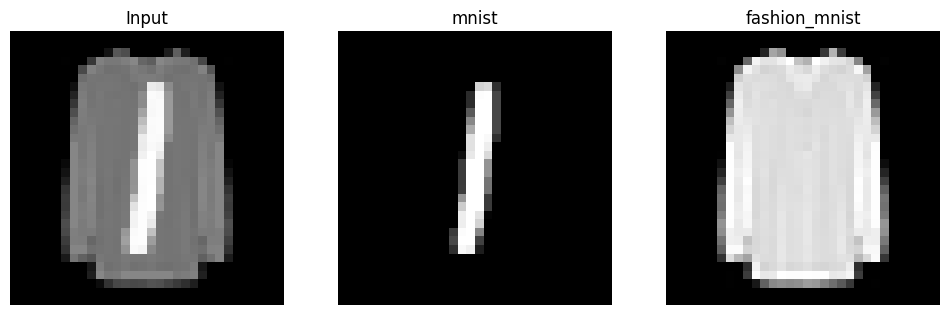

In [7]:
x,(y1,y2)=next(onegen)
show_images(x[0],y1[0],y2[0])

# Model evalaution

Let us define the test generator.

In [8]:
testgen = datagenerator(mnist_x_test,fashion_mnist_x_test,5000)

eval_samples_x, (eval_samples_y1, eval_sample2) = next(testgen)

We test a model returning twice the input image. You will need to replace it with your own predictive model.

In [ ]:
from tensorflow.keras import models
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau


def build_model_tuned(hp, input_shape=(32, 32, 1)):
    inputs = layers.Input(shape=input_shape)

    # --- Encoder ---
    # Block 1: You can tune the number of filters and dropout rate.
    filters_1 = hp.Choice('filters_1', values=[32, 64, 128])
    dropout_rate = hp.Float('dropout_rate', min_value=0.0, max_value=0.5, step=0.1, default=0.0)

    # conv_block and residual_block can use these hyperparameters
    def conv_block(x, filters, kernel_size=3, dropout_rate=0.0):
        x = layers.Conv2D(filters, kernel_size, padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = layers.ReLU()(x)
        if dropout_rate:
            x = layers.Dropout(dropout_rate)(x)
        return x

    def residual_block(x, filters, kernel_size=3, dropout_rate=0.0):
        shortcut = x
        if x.shape[-1] != filters:
            shortcut = layers.Conv2D(filters, 1, padding='same')(shortcut)
        x = conv_block(x, filters, kernel_size, dropout_rate)
        x = layers.Conv2D(filters, kernel_size, padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = layers.Add()([x, shortcut])
        x = layers.ReLU()(x)
        return x

    # Block 1
    x = conv_block(inputs, filters_1, kernel_size=3, dropout_rate=dropout_rate)
    x = residual_block(x, filters_1, kernel_size=3, dropout_rate=dropout_rate)
    skip1 = x  # Save for skip connection in the decoder
    x = layers.MaxPooling2D((2, 2), padding='same')(x)

    # Block 2: Tune the number of filters here as well.
    filters_2 = hp.Choice('filters_2', values=[64, 80, 96])
    
    x = conv_block(x, filters_2, kernel_size=3, dropout_rate=dropout_rate)
    x = residual_block(x, filters_2, kernel_size=3, dropout_rate=dropout_rate)
    skip2 = x  # Save for skip connection in the decoder
    x = layers.MaxPooling2D((2, 2), padding='same')(x)

    # Bottleneck: You might want to tune this too.
    filters_bottleneck = hp.Choice('filters_bottleneck', values=[128, 160])
    x = conv_block(x, filters_bottleneck, kernel_size=3, dropout_rate=dropout_rate)
    x = residual_block(x, filters_bottleneck, kernel_size=3, dropout_rate=dropout_rate)

    # --- Decoder for MNIST output (branch 1) ---
    d1 = layers.UpSampling2D((2, 2))(x)
    d1 = layers.concatenate([d1, skip2])  # Skip connection
    d1 = conv_block(d1, filters_2, kernel_size=3, dropout_rate=dropout_rate)
    d1 = residual_block(d1, filters_2, kernel_size=3, dropout_rate=dropout_rate)
    d1 = layers.UpSampling2D((2, 2))(d1)
    d1 = layers.concatenate([d1, skip1])
    d1 = conv_block(d1, filters_1, kernel_size=3, dropout_rate=dropout_rate)
    d1 = residual_block(d1, filters_1, kernel_size=3, dropout_rate=dropout_rate)
    output1 = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(d1)
    # Reshape to (32, 32) to match ground truth shape
    output1 = layers.Reshape((32, 32), name='mnist_output')(output1)

    # --- Decoder for Fashion-MNIST output (branch 2) ---
    d2 = layers.UpSampling2D((2, 2))(x)
    d2 = layers.concatenate([d2, skip2])
    d2 = conv_block(d2, filters_2, kernel_size=3, dropout_rate=dropout_rate)
    d2 = residual_block(d2, filters_2, kernel_size=3, dropout_rate=dropout_rate)
    d2 = layers.UpSampling2D((2, 2))(d2)
    d2 = layers.concatenate([d2, skip1])
    d2 = conv_block(d2, filters_1, kernel_size=3, dropout_rate=dropout_rate)
    d2 = residual_block(d2, filters_1, kernel_size=3, dropout_rate=dropout_rate)
    output2 = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(d2)
    output2 = layers.Reshape((32, 32), name='fashion_output')(output2)

    model = models.Model(inputs=inputs, outputs=[output1, output2])

    # Tune learning rate for the optimizer
    learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mse', 'mse'])
    return model

In [10]:
tuner = kt.RandomSearch(
    build_model_tuned,
    objective='val_loss',
    max_trials=32,
    directory='hyperparam_tuning',
    project_name='blind_source_separation',
    seed=seed
)

Reloading Tuner from hyperparam_tuning/blind_source_separation/tuner0.json


In [ ]:
# Define the batch size
batch_size = 32

# Create the generators
train_generator = datagenerator(mnist_x_train, fashion_mnist_x_train, batch_size)
val_generator = datagenerator(mnist_x_test, fashion_mnist_x_test, batch_size)

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

steps_per_epoch = len(mnist_x_train) // batch_size
validation_steps = len(mnist_x_test) // batch_size

tuner.search(
    train_generator,
    epochs=5,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_generator,
    validation_steps=validation_steps,
    callbacks=[early_stop, reduce_lr]
)

Trial 1 Complete [00h 08m 46s]
val_loss: 0.0024071859661489725

Best val_loss So Far: 0.0024071859661489725
Total elapsed time: 00h 08m 46s

Search: Running Trial #2

Value             |Best Value So Far |Hyperparameter
64                |64                |filters_1
0.2               |0                 |dropout_rate
64                |80                |filters_2
128               |128               |filters_bottleneck
0.01              |0.0001            |learning_rate

Epoch 1/5


In [11]:
best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]
print("Best hyperparameters:", best_hp.values)

# Build the best model:
best_model = build_model_tuned(best_hp)
best_model.summary()

Best hyperparameters: {'filters_1': 64, 'dropout_rate': 0.0, 'filters_2': 80, 'filters_bottleneck': 128, 'learning_rate': 0.0001}


I0000 00:00:1738777605.826393   32759 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4600 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1060 6GB, pci bus id: 0000:06:00.0, compute capability: 6.1
I0000 00:00:1738777706.230520     417 service.cc:148] XLA service 0x7f77c0002b80 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1738777706.230754     417 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce GTX 1060 6GB, Compute Capability 6.1
I0000 00:00:1738777711.232950     417 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1738777722.504398     417 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 32, 32, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 32, 32,    │        640 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 32, 32,    │        256 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, 32, 32,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 32, 32,    │     36,928 │ re_lu[0][0]       │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_1 (ReLU)      │ (None, 32, 32,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 32, 32,    │     36,928 │ re_lu_1[0][0]     │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        256 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 32, 32,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │ re_lu[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_2 (ReLU)      │ (None, 32, 32,    │          0 │ add[0][0]         │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 16, 16,    │          0 │ re_lu_2[0][0]     │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 16, 16,    │     46,160 │ max_pooling2d[0]… │
│                     │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 16,    │        320 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_3 (ReLU)      │ (None, 16, 16,    │          0 │ batch_normalizat… │
│                     │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 16, 16,    │     57,680 │ re_lu_3[0][0]     │
│                     │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 16,    │        320 │ conv2d_4[0][0]  

 Total params: 1,475,474 (5.63 MB)

 Trainable params: 1,472,114 (5.62 MB)

 Non-trainable params: 3,360 (13.12 KB)

In [13]:
# Define the batch size
batch_size = 32

# Create the generators
train_generator = datagenerator(mnist_x_train, fashion_mnist_x_train, batch_size)
val_generator = datagenerator(mnist_x_test, fashion_mnist_x_test, batch_size)

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

steps_per_epoch = len(mnist_x_train) // batch_size
validation_steps = len(mnist_x_test) // batch_size

history = best_model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=5,
    validation_data=val_generator,
    validation_steps=validation_steps,
    callbacks=[early_stop, reduce_lr]
)

Epoch 1/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 128s 52ms/step - fashion_output_loss: 0.0127 - fashion_output_mse: 0.0127 - loss: 0.0194 - mnist_output_loss: 0.0067 - mnist_output_mse: 0.0067 - val_fashion_output_loss: 0.0025 - val_fashion_output_mse: 0.0025 - val_loss: 0.0043 - val_mnist_output_loss: 0.0019 - val_mnist_output_mse: 0.0019 - learning_rate: 1.0000e-04
Epoch 2/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 96s 51ms/step - fashion_output_loss: 0.0023 - fashion_output_mse: 0.0023 - loss: 0.0040 - mnist_output_loss: 0.0017 - mnist_output_mse: 0.0017 - val_fashion_output_loss: 0.0019 - val_fashion_output_mse: 0.0019 - val_loss: 0.0033 - val_mnist_output_loss: 0.0014 - val_mnist_output_mse: 0.0014 - learning_rate: 1.0000e-04
Epoch 3/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 95s 51ms/step - fashion_output_loss: 0.0018 - fashion_output_mse: 0.0018 - loss: 0.0032 - mnist_output_loss: 0.0014 - mnist_output_mse: 0.0014 - val_fashion_output_loss: 0.0016 - val_fashion_output_mse: 0.0016 - val_loss: 0.0029 - val_m

In [14]:
def eval_model(model):
  x, (y1,y2) = next(testgen)

  # use model.predict to get predictions. Here we just call model
  pred1, pred2 = model.predict(x)

  return (np.mean((pred1-y1)**2) + np.mean((pred2-y2)**2) / 2)

In [15]:
repeat_eval = 2
eval_results = []
for i in range(repeat_eval):
  eval_results.append(eval_model(best_model))
print("mse = ", np.mean(eval_results))
print("standard deviation = ", np.std(eval_results))

157/157 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step
mse =  0.001670806315150234
standard deviation =  1.681049689446982e-05


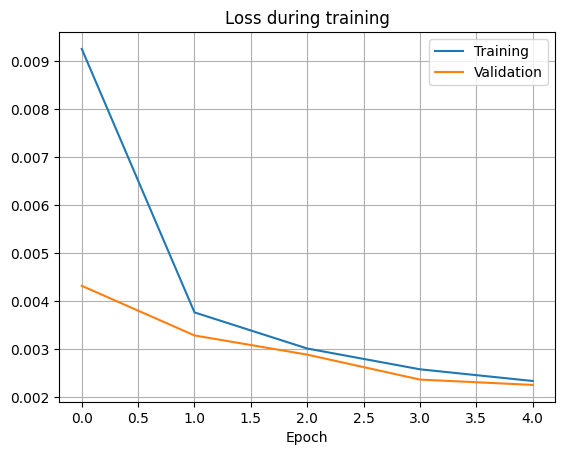

In [16]:
def display_history(history):
    mse_training = history.history['loss']
    # acc_training = history.history['accuracy']

    mse_val = history.history['val_loss']
    # acc_val = history.history['val_accuracy']

    # Visualize the behavior of the loss
    plt.plot(mse_training)
    plt.plot(mse_val)
    plt.grid()
    plt.title('Loss during training')
    plt.xlabel('Epoch')
    plt.legend(['Training', 'Validation'])
    plt.show()

    # # and of the accuracy
    # plt.plot(acc_training)
    # plt.plot(acc_val)
    # plt.grid()
    # plt.title('Accuracy during training')
    # plt.xlabel('Epoch')
    # plt.legend(['Training', 'Validation'])
    # plt.show()

# print(history.model.summary())
display_history(history)


 --------- IMAGE 1 --------- 



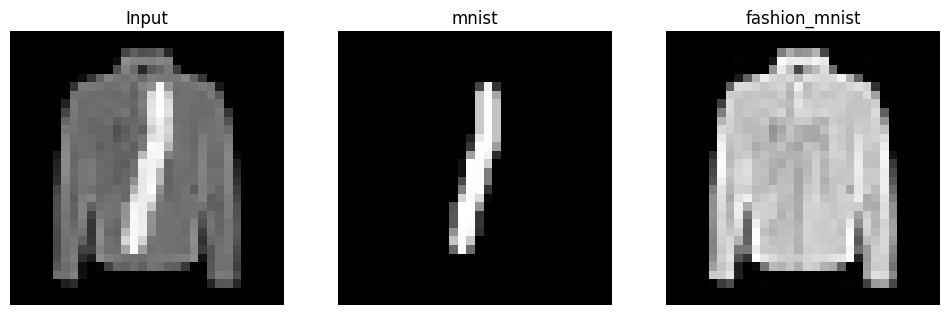

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Predictions:


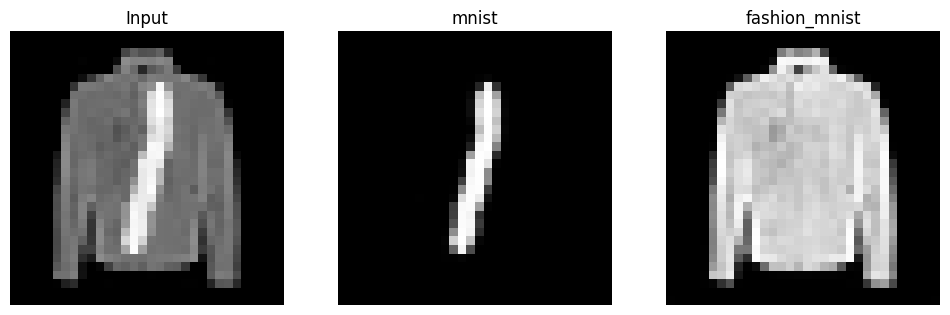




 --------- IMAGE 2 --------- 



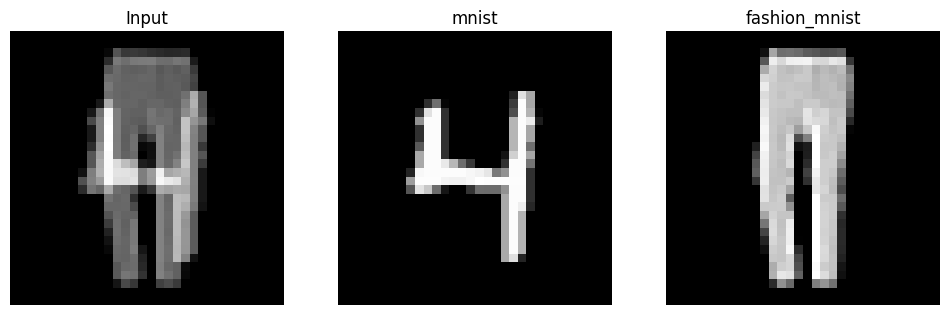

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
Predictions:


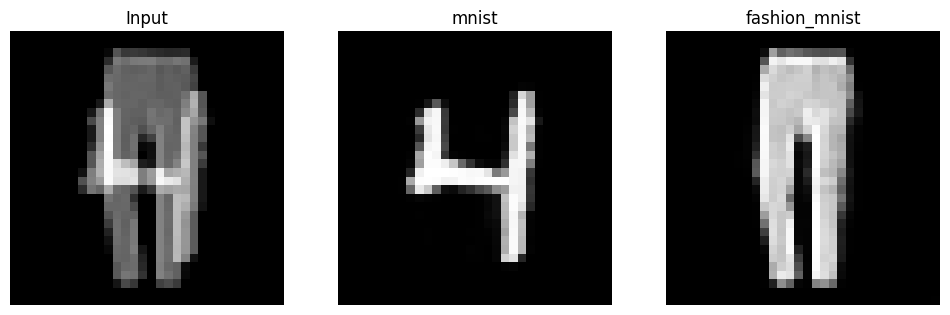




 --------- IMAGE 3 --------- 



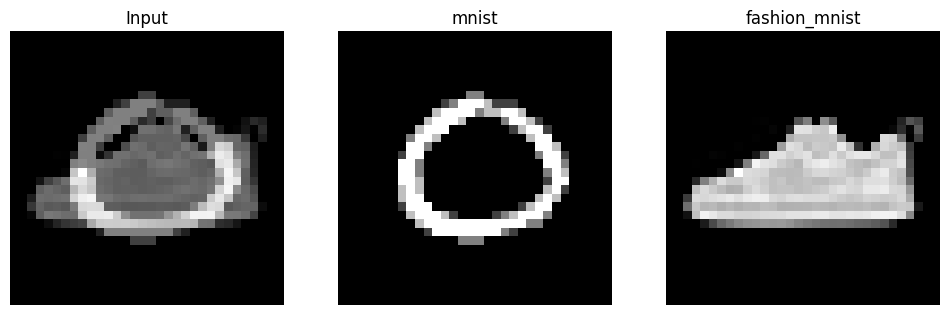

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Predictions:


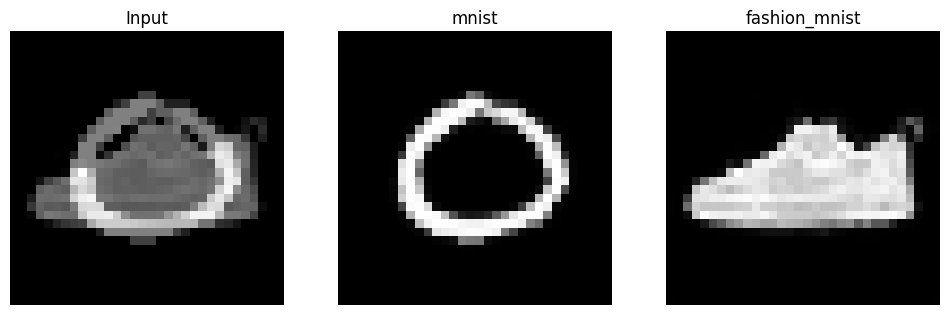




 --------- IMAGE 4 --------- 



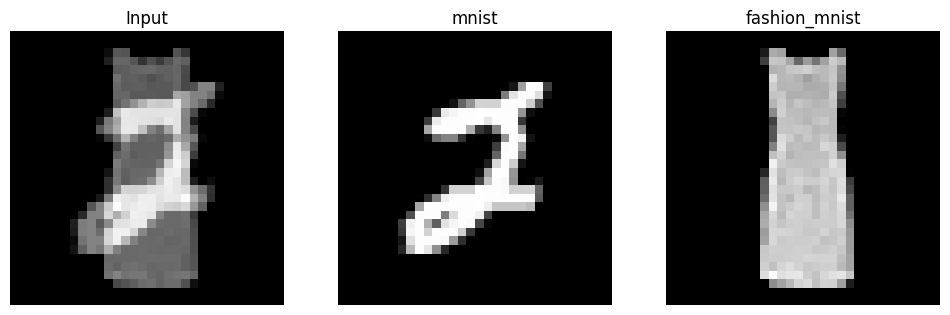

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Predictions:


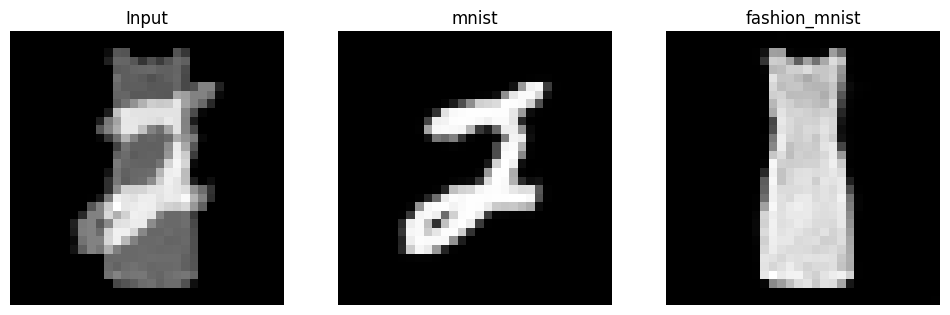




 --------- IMAGE 5 --------- 



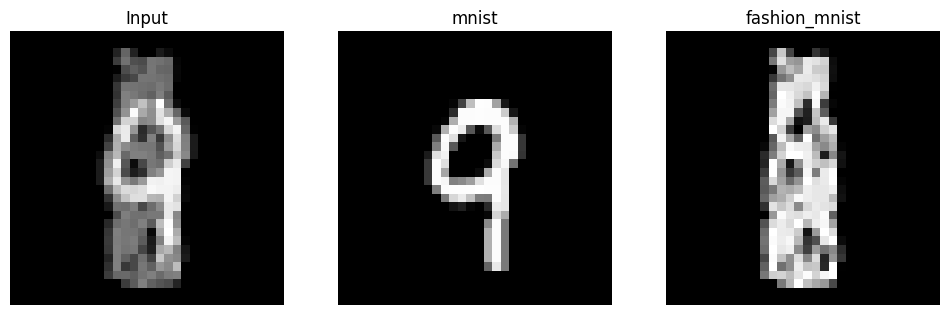

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Predictions:


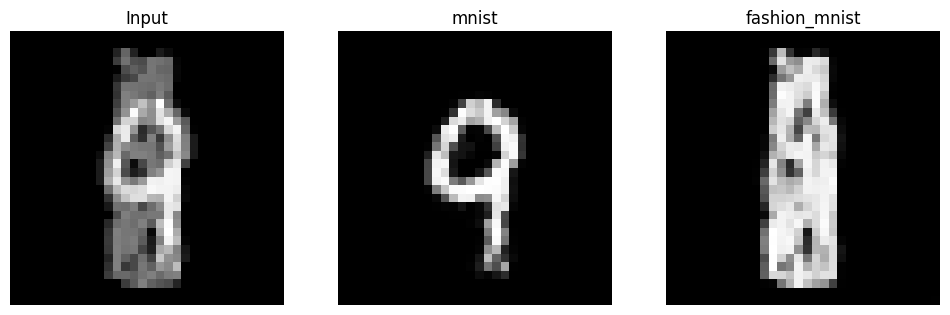




 --------- IMAGE 6 --------- 



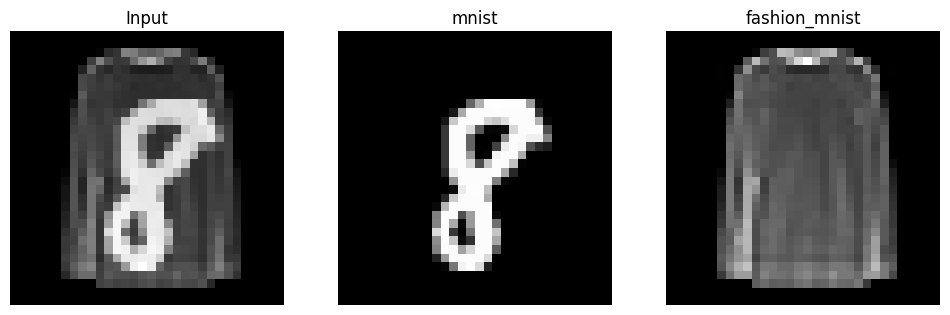

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Predictions:


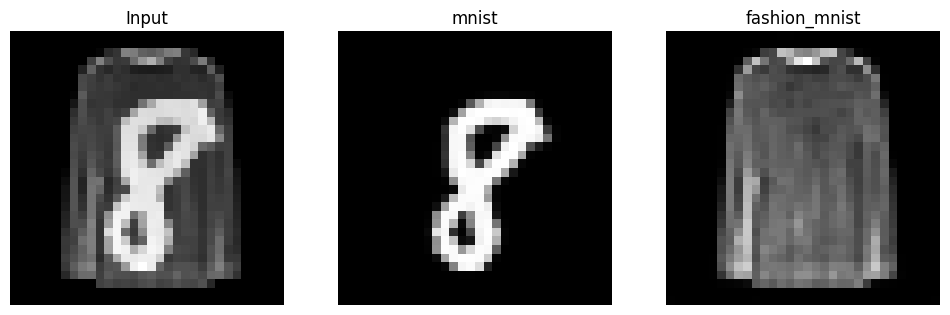




 --------- IMAGE 7 --------- 



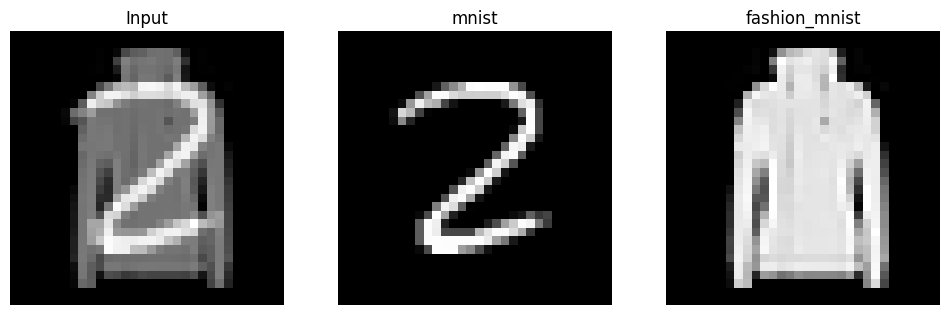

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Predictions:


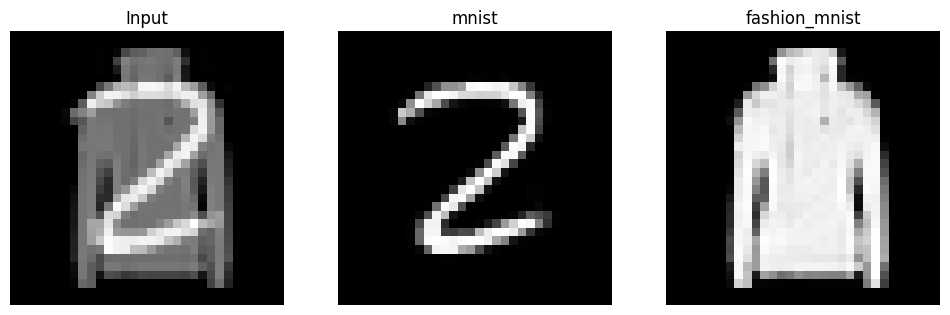




 --------- IMAGE 8 --------- 



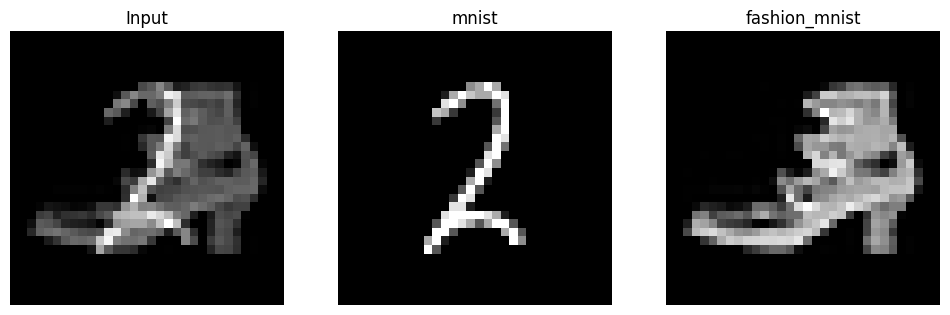

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Predictions:


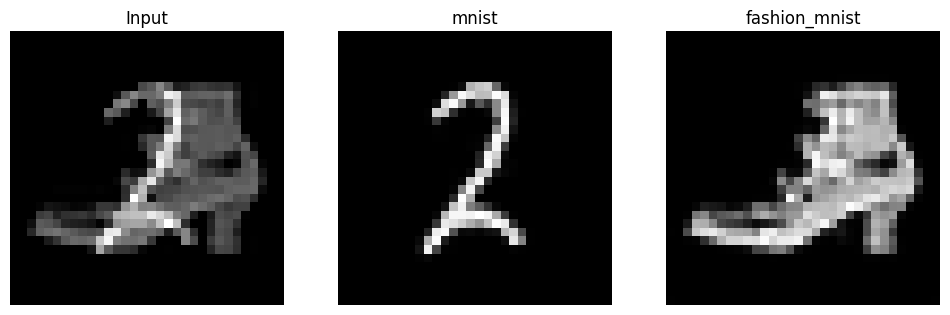




 --------- IMAGE 9 --------- 



IndexError: index 8 is out of bounds for axis 0 with size 8

In [19]:
batch_visual_gen = 8
visual_test_generator = datagenerator(mnist_x_test, fashion_mnist_x_test, batch_visual_gen)

def visual_test(generator, model, n_images=1):
    x_test, y_test = next(generator)

    for i in range(n_images):
        print(f'\n --------- IMAGE {i+1} --------- \n')
        # Create the grid
        show_images(x_test[i], y_test[0][i], y_test[1][i])
        
        # Get the prediction
        pred1, pred2 = model.predict(x_test[i][np.newaxis, ...])
        
        # Display the prediction
        print('Predictions:')
        show_images(x_test[i], pred1[0], pred2[0])
        print('\n')
        
        plt.show()
        
visual_test(visual_test_generator, best_model, n_images=10)

# What to deliver
As usual, you are supposed to deliver a single notebook that is supposed to run on colab. The notebook should be adequately commented, contain a full trace of the training, the computation of the mse in the form specified above and a few examples.

Good Work!